# 1. 배경

*흩어져있는 고객 데이터를 '군집'시키는 것이 목적*
* 본 프로젝트에서는 마케팅에서 보편적으로 쓰이는 방식인 RFM을 기준으로 점수를 부여하여 군집을 나누는 방안을 채택하였다.
* 그러나 업종별로 각 변수의 중요도가 다르기 때문에 회귀모델을 이용하여 가중치를 도출하였고, 도출된 가중치를 최종 RFM Score에 적용하였다.

# 2. 가중치 실험

* 1년간의 고객 구매데이터를 앞의 8개월과 뒤의 4개월 데이터로 분할하였다.
* 앞의 8개월 데이터에서는 R,F,M 값을 관측하고 뒤의 4개월 데이터에서는 해당 기간 동안의 구매 여부를 1(구매함)과 0(구매하지 않음)으로 코딩하여 이분형 자료를 만들었다. 
* 이렇게 두 개로 나뉜 데이터를 비교하여 예측되는 값을 토대로 가중치로 선택하였다.
* 참고 논문 출처: 김동석, <RFM 모형의 가중치 선택에 관한 연구>

## 2.1 데이터 불러오기

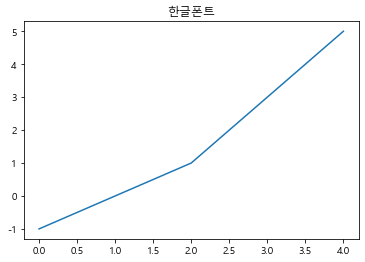

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rc("font", family="Malgun Gothic") #한글 폰트 
plt.rc("axes", unicode_minus=False) #마이너스 코드 
import time 
pd.Series([-1,0,1,3,5]).plot(title="한글폰트") # 한글폰트와 마이너스 폰트 설정 확인
from IPython.display import set_matplotlib_formats #폰트 선명하게 설정.
import warnings # 경고메세지 무시하기
warnings.filterwarnings(action='ignore')

In [2]:
df_shop = pd.read_csv('data/df_shop.csv')
# df_shop = df_shop.drop(columns='Unnamed: 0', axis=1)
print(df_shop.shape)
df_shop.head()

(3447070, 14)


,ID,성별,연령대,시도,시군구,총_쇼핑소비금액,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명
0,1,남성,60대,서울특별시,강동구,3899130,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정
1,1,남성,60대,서울특별시,강동구,3899130,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정
2,1,남성,60대,서울특별시,강동구,3899130,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠
3,1,남성,60대,서울특별시,강동구,3899130,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류
4,1,남성,60대,서울특별시,강동구,3899130,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품


In [3]:
df_shop = df_shop.drop(columns = ['총_쇼핑소비금액'])

df_shop['구매일자'] = df_shop['구매일자'].astype('datetime64')
df_shop['구매월'] = df_shop['구매일자'].dt.month
df_shop.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,구매월
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,12
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,5
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,8
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,12
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,5


In [4]:
df_shop.columns

Index(['ID', '성별', '연령대', '시도', '시군구', '구매일자', '구매시간', '구매금액', '구매수량', '업종',
       '소분류명', '중분류명', '대분류명', '구매월'],
      dtype='object')

In [5]:
df_shop[['ID', '성별', '연령대', '시도', '시군구', '구매시간', '업종',
       '소분류명', '중분류명', '대분류명']]

,ID,성별,연령대,시도,시군구,구매시간,업종,소분류명,중분류명,대분류명
0,1,남성,60대,서울특별시,강동구,17,백화점,수입주방,주방용품,가정
1,1,남성,60대,서울특별시,강동구,14,백화점,수입주방,주방용품,가정
2,1,남성,60대,서울특별시,강동구,19,백화점,N/B골프의류,골프용품,스포츠
3,1,남성,60대,서울특별시,강동구,12,백화점,란제리,란제리/내의,여성의류
4,1,남성,60대,서울특별시,강동구,12,백화점,어묵,젓갈/반찬,식품
...,...,...,...,...,...,...,...,...,...,...
3447065,19998,남성,40대,경상남도,김해시,17,대형마트,남성병행수입,병행수입,남성의류편집
3447066,19998,남성,40대,경상남도,김해시,14,대형마트,일반화장품,기초화장품,브랜드화장품
3447067,19998,남성,40대,경상남도,김해시,14,대형마트,일반화장품,기초화장품,브랜드화장품
3447068,19998,남성,40대,경상남도,김해시,14,대형마트,일반화장품,기초화장품,브랜드화장품


In [6]:
df_shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447070 entries, 0 to 3447069
Data columns (total 14 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ID      int64         
 1   성별      object        
 2   연령대     object        
 3   시도      object        
 4   시군구     object        
 5   구매일자    datetime64[ns]
 6   구매시간    int64         
 7   구매금액    int64         
 8   구매수량    int64         
 9   업종      object        
 10  소분류명    object        
 11  중분류명    object        
 12  대분류명    object        
 13  구매월     int64         
dtypes: datetime64[ns](1), int64(5), object(8)
memory usage: 368.2+ MB


In [7]:
# 12개월 기준으로 8개월과 4개월을 분리

df_shop_aug = df_shop[df_shop['구매월']<=8]
df_shop_nov = df_shop[df_shop['구매월']>8]

In [8]:
df_shop_aug.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,구매월
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,5
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,8
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,5
5,1,남성,60대,서울특별시,강동구,2015-05-13,12,6900,1,백화점,어묵,젓갈/반찬,식품,5
6,1,남성,60대,서울특별시,강동구,2015-05-13,12,2400,2,백화점,어묵,젓갈/반찬,식품,5


In [9]:
df_shop_nov.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,구매월
0,1,남성,60대,서울특별시,강동구,2015-12-16,17,28000,1,백화점,수입주방,주방용품,가정,12
3,1,남성,60대,서울특별시,강동구,2015-12-28,12,166000,1,백화점,란제리,란제리/내의,여성의류,12
8,1,남성,60대,서울특별시,강동구,2015-11-04,18,3200,1,백화점,디저트류,차/커피,식품,11
12,1,남성,60대,서울특별시,강동구,2015-11-21,15,29000,1,백화점,유아복,아동,아동,11
13,1,남성,60대,서울특별시,강동구,2015-11-21,15,47000,1,백화점,유아복,아동,아동,11


## 2.2 가중치를 구하기 위한 로지스틱 회귀 모델 생성
* 8개월 데이터의 RFM 분석으로 4개월 데이터에 영향을 미치는 요인의 우선순위를 찾아 가중치를 구하고자 한다.
* 그 과정에서 데이터 특성상 목표변수를 생성할 수 있어(구매/비구매) 로지스틱 회귀 모델을 이용하였다.

### 2.2.1 8개월 데이터의 RFM

In [10]:
# Monetary 변수 생성

df_shop_aug['총쇼핑금액'] = df_shop_aug['구매금액'] * df_shop_aug['구매수량'] # 수량 * 가격

# 고객별 총 거래 수익

rfm_aug_m = pd.DataFrame(df_shop_aug.groupby('ID')['총쇼핑금액'].sum().reset_index())
rfm_aug_m.columns = ['CustomerID', 'Monetary']
rfm_aug_m.head()

,CustomerID,Monetary
0,1,2661130
1,2,2757892
2,3,170427845
3,4,75739142
4,6,303361931


In [11]:
# Frequency 변수 생성

# 고객별 구매 횟수

rfm_aug_f = pd.DataFrame(df_shop_aug.groupby(['ID'])['구매일자'].count().reset_index())
rfm_aug_f.columns = ['CustomerID', 'Frequency']
rfm_aug_f.head()

,CustomerID,Frequency
0,1,38
1,2,171
2,3,51
3,4,216
4,6,660


In [12]:
# Recency 변수 생성

# 이 데이터셋의 가장 최근 날짜
max_date = max(df_shop_aug['구매일자'])
max_date

Timestamp('2015-08-31 00:00:00')

In [13]:
df_shop_aug['구매텀'] = max_date - df_shop_aug['구매일자']
df_shop_aug.head()

,ID,성별,연령대,시도,시군구,구매일자,구매시간,구매금액,구매수량,업종,소분류명,중분류명,대분류명,구매월,총쇼핑금액,구매텀
1,1,남성,60대,서울특별시,강동구,2015-05-13,14,15000,1,백화점,수입주방,주방용품,가정,5,15000,110 days
2,1,남성,60대,서울특별시,강동구,2015-08-01,19,166400,1,백화점,N/B골프의류,골프용품,스포츠,8,166400,30 days
4,1,남성,60대,서울특별시,강동구,2015-05-13,12,1000,2,백화점,어묵,젓갈/반찬,식품,5,2000,110 days
5,1,남성,60대,서울특별시,강동구,2015-05-13,12,6900,1,백화점,어묵,젓갈/반찬,식품,5,6900,110 days
6,1,남성,60대,서울특별시,강동구,2015-05-13,12,2400,2,백화점,어묵,젓갈/반찬,식품,5,4800,110 days


In [14]:
# 최신성을 얻기 위해 고객별 마지막 거래가 얼마나 지났는지 알아보기

rfm_aug_r = pd.DataFrame(df_shop_aug.groupby('ID')['구매텀'].min().reset_index())
rfm_aug_r['구매텀'] = rfm_aug_r['구매텀'].dt.days # 일수만 추출
rfm_aug_r.columns = ['CustomerID', 'Recency']
rfm_aug_r.head()

,CustomerID,Recency
0,1,26
1,2,15
2,3,15
3,4,3
4,6,0


In [15]:
# r, f, m을 merge

rf_aug_merge = pd.merge(rfm_aug_m, rfm_aug_f, on='CustomerID', how='inner')
rfm_aug = pd.merge(rf_aug_merge, rfm_aug_r, on='CustomerID', how='inner')
rfm_aug.head()

,CustomerID,Monetary,Frequency,Recency
0,1,2661130,38,26
1,2,2757892,171,15
2,3,170427845,51,15
3,4,75739142,216,3
4,6,303361931,660,0


### 2.2.2 이상치 탐색 및 제거

Text(0, 0.5, '범위')

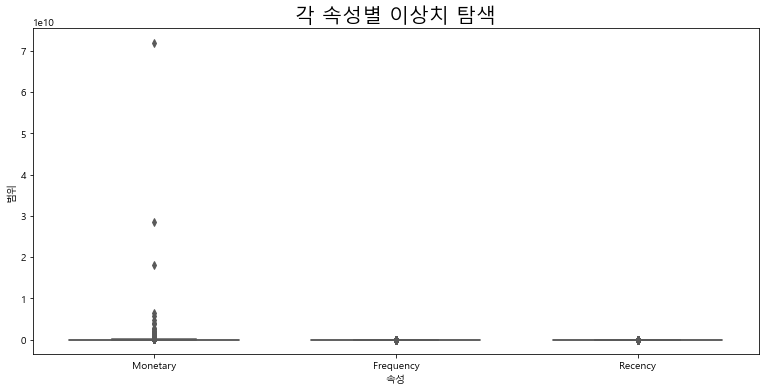

In [16]:
속성 = ['Monetary', 'Frequency', 'Recency']

plt.figure(figsize = (13, 6))
sns.boxplot(data=rfm_aug[속성], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title('각 속성별 이상치 탐색', fontsize=20)
plt.xlabel('속성')
plt.ylabel('범위')

'Monetary' 변수에 이상치가 보이므로 이상치를 제거해주도록 한다

In [17]:
# 사분위수를 기준으로 이상치 제거

Q1 = rfm_aug.Monetary.quantile(0.25)
Q3 = rfm_aug.Monetary.quantile(0.75)
IQR = Q3 - Q1

# 해당하는 값의 범위만 rfm_aug에 다시 할당
# 즉, 이상치를 제외

rfm_aug = rfm_aug[(rfm_aug.Monetary >= Q1 - 1.5*IQR) & (rfm_aug.Monetary <= Q3 + 1.5*IQR)] 

# 이상치 처리시 다른 속성들도 같은 갯수여야 하므로 Frequency, Recency도 똑같이 처리

Q1 = rfm_aug.Frequency.quantile(0.25)
Q3 = rfm_aug.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm_aug = rfm_aug[(rfm_aug.Frequency >= Q1 - 1.5*IQR) & (rfm_aug.Frequency <= Q3 + 1.5*IQR)]


Q1 = rfm_aug.Recency.quantile(0.25)
Q3 = rfm_aug.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm_aug = rfm_aug[(rfm_aug.Recency >= Q1 - 1.5*IQR) & (rfm_aug.Recency <= Q3 + 1.5*IQR)]

<AxesSubplot:xlabel='Monetary'>

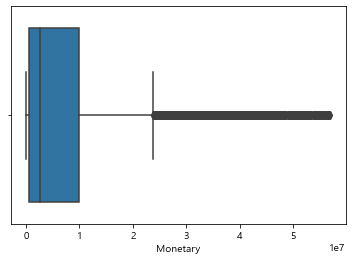

In [18]:
sns.boxplot(rfm_aug['Monetary'])

<AxesSubplot:xlabel='Frequency'>

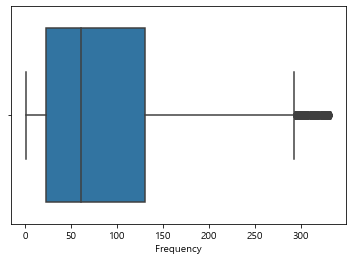

In [19]:
sns.boxplot(rfm_aug['Frequency'])

<AxesSubplot:xlabel='Recency'>

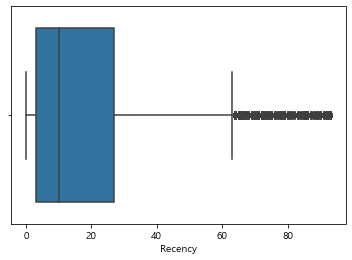

In [20]:
sns.boxplot(rfm_aug['Recency'])

### 2.2.3 4개월 데이터 구매여부 컬럼 생성
* 0: 구매 X
* 1: 구매 O

In [21]:
df_shop_nov['y'] = df_shop_nov['구매금액'] * df_shop_nov['구매수량'] # 수량 * 가격


In [22]:
# 변수생성
# 총쇼핑금액으로 8개월 데이터 구매자가 4개월 데이터에서 구매했는지 알아보고자 각각의 총 쇼핑금액으로 merge 실행
# y값이 비어있는경우, 4개월 데이터에서는 구매하지 않은 것.

aug_money = pd.DataFrame(df_shop_aug.groupby('ID')['총쇼핑금액'].sum()).reset_index()  # 8개월 데이터에서의 고객별 총 쇼핑금액
nov_money = pd.DataFrame(df_shop_nov.groupby('ID')['y'].sum()).reset_index()  # 4개월 데이터에서의 고객별 총 쇼핑금액(y)
money = pd.DataFrame(pd.merge(aug_money, nov_money, how='left', on='ID')) # 위 두개의 데이터를 합친 데이터

In [23]:
print(aug_money.shape, nov_money.shape)

(16315, 2) (15240, 2)


In [24]:
money.head()

,ID,총쇼핑금액,y
0,1,2661130,1238000.0
1,2,2757892,29835268.0
2,3,170427845,15620779.0
3,4,75739142,43509080.0
4,6,303361931,67669959.0


In [25]:
money.shape

(16315, 3)

In [26]:
# 비어있는 값 0으로 채움

money['y'] = money['y'].fillna(0)

In [27]:
# 값이 0이 아닌경우에는 다 1로 바꾸기

money['y'][money['y'] != 0] = 1

In [28]:
# 구매함 : 1, 구매하지 않음 : 0

money = money.drop(columns='총쇼핑금액', axis=1)
money = money.rename(columns={'y':'구매여부'})
money.head()

,ID,구매여부
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,6,1.0


In [29]:
# 최종데이터 (8개월 데이터에 구매여부를 생성)

rfm_aug_binary = pd.merge(rfm_aug,money, how='inner', left_on='CustomerID', right_on='ID')
rfm_aug_binary = rfm_aug_binary.drop(columns='ID', axis=1)
rfm_aug_binary.head()

,CustomerID,Monetary,Frequency,Recency,구매여부
0,1,2661130,38,26,1.0
1,2,2757892,171,15,1.0
2,7,1007480,41,5,1.0
3,8,26140557,219,4,1.0
4,9,42598356,115,6,1.0


In [30]:
rfm_aug_binary.shape

(11542, 5)

In [31]:
rfm_aug_binary['구매여부'].value_counts()

1.0    10621
0.0      921
Name: 구매여부, dtype: int64

In [32]:
rfm_aug_binary.isnull().sum()

CustomerID    0
Monetary      0
Frequency     0
Recency       0
구매여부          0
dtype: int64

In [33]:
rfm_aug_binary['구매여부'] = rfm_aug_binary['구매여부'].astype('int')

In [34]:
rfm_aug_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11542 entries, 0 to 11541
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   CustomerID  11542 non-null  int64
 1   Monetary    11542 non-null  int64
 2   Frequency   11542 non-null  int64
 3   Recency     11542 non-null  int64
 4   구매여부        11542 non-null  int32
dtypes: int32(1), int64(4)
memory usage: 495.9 KB


In [35]:
rfm_aug_binary['Recency'].value_counts()

1     1044
0      915
2      903
3      622
4      473
      ... 
83      15
88      15
84      15
87      13
82      12
Name: Recency, Length: 94, dtype: int64

<AxesSubplot:xlabel='Recency', ylabel='Density'>

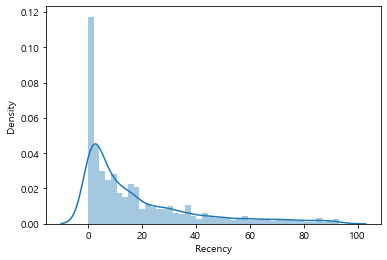

In [36]:
sns.distplot(rfm_aug_binary['Recency'])

변수들의 값 범위가 정규분포 형태로 이루어져 있지 않아 log값을 씌워주었다

In [37]:
rfm_aug_binary_log = rfm_aug_binary[['Monetary', 'Frequency', 'Recency']].apply(np.log1p, axis=1).round(3)
rfm_aug_binary_log['구매여부'] = rfm_aug_binary['구매여부']
rfm_aug_binary_log

,Monetary,Frequency,Recency,구매여부
0,14.794,3.664,3.296,1
1,14.830,5.147,2.773,1
2,13.823,3.738,1.792,1
3,17.079,5.394,1.609,1
4,17.567,4.754,1.946,1
...,...,...,...,...
11537,11.543,2.708,0.693,1
11538,10.382,2.944,0.000,1
11539,10.789,1.792,2.079,1
11540,14.877,2.303,2.639,1


In [38]:
rfm_aug_binary_log.isnull().sum()

Monetary     0
Frequency    0
Recency      0
구매여부         0
dtype: int64

### 2.2.4 Scaling

- 로지스틱 회귀분석에 앞서 각각 변수의 범위가 차이가 많이나므로 스케일링을 진행하였다

In [39]:
from sklearn.preprocessing import StandardScaler

rfm_aug_log = rfm_aug_binary_log[['Monetary', 'Frequency', 'Recency']]

scaler = StandardScaler()

# fit_transform
scaled_rfm_aug = scaler.fit_transform(rfm_aug_log)
print(scaled_rfm_aug.shape)
scaled_rfm_aug = pd.DataFrame(scaled_rfm_aug)
scaled_rfm_aug.columns = ['Monetary', 'Frequency', 'Recency']
scaled_rfm_aug

(11542, 3)


,Monetary,Frequency,Recency
0,0.090829,-0.235907,0.797702
1,0.109579,1.011220,0.381980
2,-0.414885,-0.173676,-0.397795
3,1.280898,1.218935,-0.543258
4,1.535057,0.680727,-0.275384
...,...,...,...
11537,-1.602349,-1.039854,-1.271367
11538,-2.207019,-0.841390,-1.822218
11539,-1.995046,-1.810163,-0.169665
11540,0.134057,-1.380438,0.275467


In [40]:
scaled_rfm_aug['CustomerID'] = rfm_aug_binary['CustomerID']
scaled_rfm_aug['구매여부'] = rfm_aug_binary['구매여부']
scaled_rfm_aug = scaled_rfm_aug[['CustomerID', 'Monetary', 'Frequency', 'Recency', '구매여부']]
scaled_rfm_aug['구매여부'] = scaled_rfm_aug['구매여부'].astype('int')

In [41]:
# 모델 학습에 있어 CustomerID는 제거.

scaled_rfm_aug = scaled_rfm_aug.drop(columns='CustomerID', axis=1)
scaled_rfm_aug.head()

,Monetary,Frequency,Recency,구매여부
0,0.090829,-0.235907,0.797702,1
1,0.109579,1.011220,0.381980,1
2,-0.414885,-0.173676,-0.397795,1
3,1.280898,1.218935,-0.543258,1
4,1.535057,0.680727,-0.275384,1


### 2.2.5 로지스틱 회귀 모델 생성 

In [42]:
# 구매여부는 y값이므로 제외. 나머지 컬럼들을 X로 지정

feature_columns = scaled_rfm_aug.columns.difference(['구매여부'])

# 독립변수와 종속변수를 지정
# 독립변수(feature_columns): Monetary, Frequency, Recency
# 종속변수(y): 구매여부

X = scaled_rfm_aug[feature_columns] 
y = scaled_rfm_aug['구매여부']


# 훈련세트와 테스트 세트 생성 
train_x, test_x ,train_y, test_y = train_test_split(X, y, stratify=y,train_size=0.7,test_size=0.3,random_state=42)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(8079, 3) (3463, 3) (8079,) (3463,)


In [43]:
# 로지스틱 회귀분석 모델 생성 후 훈련

model = LogisticRegression(random_state=42)
model.fit(train_x, train_y)

LogisticRegression(random_state=42)

### 2.2.6 GridSearchCV를 이용한 하이퍼 파라미터 튜닝

In [44]:
# GridSearchCV로 최적의 파라미터 값 찾기

from sklearn.model_selection import GridSearchCV

parameters = {'C':[0.001, 0.01, 0.1, 1, 10], 'penalty' : ['l1', 'l2']}
grid_search = GridSearchCV(model, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(train_x, train_y)

# penalty = 'L2'와 'l1', 규제(오버피팅을 방지)의 릿지와 라쏘
# L2는 페널티를 가하게 되면서 변수의 값이 0에 가까워진다. 
# L1는 0이되는 그런 형태
# C : 규제의 정도를 나타내는 것
# C값이 커지면 규제가 느슨해져 오버피팅이 일어남, 0에 가까워지면 규제가 강해짐
# n_jobs=-1 : CPU를 다 쓴다. 
# cv=3, 교차검증의 약자로, 3-fold

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [45]:
# 최적의 파라미터 결과

grid_search.best_params_

{'C': 10, 'penalty': 'l2'}

In [46]:
# 최적의 하이퍼 파라미터가 적용된 모델로 값을 예측

model_best = grid_search.best_estimator_
y_pred = model_best.predict(test_x)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([  74, 3389], dtype=int64))

### 2.2.7 로지스틱 회귀 모델 평가

In [48]:
# 회귀모델의 정확도

from sklearn.metrics import accuracy_score
accuracy_score(test_y, y_pred)

0.9220329194340168

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = model_best.predict_proba(test_x)[:, 1]
y_pred_proba

array([0.99516133, 0.94458085, 0.99588133, ..., 0.5048821 , 0.78311217,
       0.69678089])

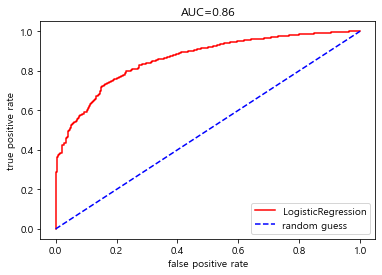

In [50]:
# ROC 그래프 

fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
auc = roc_auc_score(test_y, y_pred_proba)
plt.plot(fpr, tpr, 'r-', label='LogisticRegression')
plt.plot([0, 1], [0, 1], 'b--', label = 'random guess')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('AUC={0:.2f}'.format(auc))
plt.legend(loc='lower right');

- 로그를 하지 않았을시, 0.67
- 로그를 하였을 경우, 0.86(향상)
  - 로그를 다시 선택한 이유 : 회귀분석시, 정규성, 등분산성 검토해야하는데, 해당 데이터가 비정규성이므로 사용.

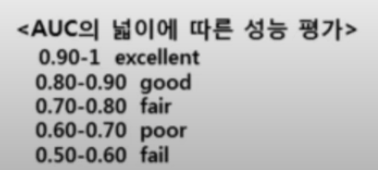

In [51]:
# 로지스틱 회귀 모형에 대한 평가 보고서

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.14      0.23       276
           1       0.93      0.99      0.96      3187

    accuracy                           0.92      3463
   macro avg       0.74      0.57      0.59      3463
weighted avg       0.90      0.92      0.90      3463



In [52]:
# 구해진 가중치 

print(train_x.columns)
model_best.coef_

Index(['Frequency', 'Monetary', 'Recency'], dtype='object')


array([[ 1.02412651,  0.23479531, -0.49357152]])

# 3. 가중치 결과

In [53]:
weight = pd.DataFrame(model_best.coef_)
weight.columns = ['Frequency', 'Monetary', 'Recency']
weight

,Frequency,Monetary,Recency
0,1.024127,0.234795,-0.493572


*R, F, M 변수 중 데이터에서 가장 중요한 변수는 Frequency로 고객의 구매에는 구매빈도가 가장 많은 영향을 미친다고 해석할 수 있다*
* 가중치 결과에 따라 최종 rfm score의 값은 1.024127×f_score + 0.234795×m_score -0.493572×r_score으로 계산할 수 있다